In [1]:
import matplotlib.pylab as plt
import os

os.environ["DJANGO_ALLOW_ASYNC_UNSAFE"] = "true"
import numpy as np
import pandas as pd

import networkx as nx
from networkx import Graph
from networkx.drawing.nx_pylab import draw
from networkx.algorithms.approximation import min_weighted_dominating_set
from networkx.algorithms.dominating import dominating_set

from dwave.system.samplers import DWaveSampler
from minorminer import find_embedding
from dwave.system.composites import EmbeddingComposite, FixedEmbeddingComposite
from dimod.utilities import qubo_to_ising
from dwave.embedding import embed_qubo

from qlp.mds import graph_tools as gt
from qlp.mds.qubo import get_mds_qubo
from qlp.mds.solver import classical_search
from qlp.mds.mds_qlpdb import (
    QUBO_to_Ising,
    retry_embedding,
    find_offset,
    AnnealOffset,
    plot_anneal_offset,
    graph_summary,
    experiment_summary,
    data_summary,
    insert_result,
)
import dwave.inspector as inspector


In [2]:
insertdb = True

nvertices = 7

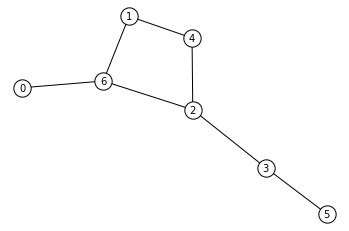

Greedy solution
 {0, 1, 2, 5}


In [26]:
#graph, tag = gt.generate_nn_graph(nvertices)
#graph, tag = gt.generate_corona_graph(2, 0)

graph, tag = gt.generate_erdos_renyi_graph(nvertices, np.log(nvertices)/nvertices)

# plot graph
gt.get_plot(graph, directed=False)
plt.show()

penalty = 2
qubo = get_mds_qubo(
    graph, directed=False, penalty=penalty, triangularize=True, dtype="d"
)

q_min = np.array(list(qubo.values())).min()

# greedy solution
G = nx.Graph()
G.add_edges_from(graph)
print("Greedy solution\n", dominating_set(G))

In [27]:
# Embedding retries
retries = 100000
# Set functional form of anneal offset
offtype = "binary"
target_min = 0.0
target_range = 0.0
problem_min = 0
problem_range = abs(problem_min)
# DWave parameters
annealing_time = 800  # integer microseconds [1, 2000] #OPTIMIZED
answer_mode = "raw"  # histogram or raw
auto_scale = True
num_reads = 1000  # raw will dump out all results
num_spin_reversal_transforms = 0 # OPTIMIZED
readout_thermalization = 0  # default 0
programming_thermalization = 1000  # default 1000

solver = "Advantage_system1.1"
sampler = DWaveSampler(solver=solver)

In [28]:
# convert to Ising
J, h, C = QUBO_to_Ising(qubo.todense().tolist())
maxJ = max(abs(J).flatten())
maxh = max(abs(h))
# Set chain strength
chain_strength = maxJ * 2

qubo_dict = {key: val for key, val in zip(qubo.keys(), qubo.values())}
qpu_graph = sampler.edgelist
embed, embedding, min_offset, max_offset = retry_embedding(
    sampler=sampler,
    qubo_dict=qubo_dict,
    qpu_graph=qpu_graph,
    graph_tag=tag,
    target_min=target_min,
    target_range=target_range,
    n_tries=retries,
    save=False
)

graph_params = graph_summary(tag, graph, qubo_dict)

# For anneal offsets
offsetcls = AnnealOffset(offtype, graph_params=graph_params)
qubo_graph = nx.Graph() 
qubo_graph.add_edges_from(sampler.edgelist)
embedded_qubo = embed_qubo(qubo_dict, embedding, qubo_graph, chain_strength)
hembed, Jembed, _ = qubo_to_ising(embedded_qubo)
graph_params = graph_summary(tag, graph, qubo_dict)
offsetcls = AnnealOffset(offtype, graph_params=graph_params)
anneal_offsets, exp_tag, _ = find_offset(
    h=hembed,
    fcn=offsetcls.fcn,
    embedding=embedding,
    offset_min=problem_min,
    offset_range=problem_range,
)

# Run Dwave
dwave_config = {
    "annealing_time": annealing_time,  # integer microseconds [1, 2000]
    "answer_mode": answer_mode,  # histogram or raw
    "auto_scale": auto_scale,
    "num_reads": num_reads,  # raw will dump out all results
    "num_spin_reversal_transforms": num_spin_reversal_transforms,
    "readout_thermalization": readout_thermalization,  # default 0
    "programming_thermalization": programming_thermalization,  # default 1000
    "chain_strength": chain_strength,
    "anneal_offsets": anneal_offsets
}

experiment_params = experiment_summary(
    machine=solver,
    settings=dwave_config,
    penalty=penalty,
    chain_strength=chain_strength,
    tag=exp_tag,
)

result = embed.sample_qubo(qubo_dict, **dwave_config)
raw = result.to_pandas_dataframe()

data_params = data_summary(raw, graph_params, experiment_params)
if insertdb:
    dbresult = insert_result(graph_params, experiment_params, data_params)

Creating new graph


In [29]:
raw.sort_values("energy", ascending=True)

,0,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,18,chain_break_fraction,energy,num_occurrences
999,1,0,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0.000000,-11.0,1
223,0,0,1,1,0,0,1,0,0,0,...,1,0,0,0,0,1,0,0.000000,-11.0,1
250,1,0,0,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0.000000,-11.0,1
252,0,0,1,1,0,0,1,0,0,0,...,1,0,0,0,0,1,0,0.000000,-11.0,1
883,1,0,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0.000000,-11.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
402,1,1,1,1,0,0,1,1,0,1,...,1,0,0,0,0,1,0,0.052632,3.0,1
256,1,1,0,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0.157895,4.0,1
838,1,0,0,1,1,0,1,1,1,0,...,1,0,0,1,0,0,0,0.000000,4.0,1
488,1,1,1,1,0,1,1,1,0,0,...,0,1,0,0,1,1,0,0.157895,6.0,1


In [7]:
#inspector.show(result.info["problem_id"])
